# **Análisis Exploratorio de Datos (EDA) - Conjunto de Datos sobre Abandono de Clientes Bancarios**

# **Definición del problema**
En este proyecto, el objetivo es predecir la probabilidad de que un cliente abandone o permanezca en el banco. Este fenómeno se conoce como Churn o abandono de clientes, un problema recurrente en la industria bancaria y otras áreas de servicios. El churn puede tener un impacto financiero significativo en las instituciones, ya que es más costoso adquirir nuevos clientes que retener a los actuales. La predicción de abandono permite a los bancos aplicar estrategias proactivas para retener a los clientes con mayor riesgo de abandono.



# 🔹 Preguntas iniciales (para limpieza y exploración de datos)

Antes de construir un modelo, necesitamos entender la calidad y estructura de los datos. Algunas preguntas clave:

Calidad de los datos

¿Existen valores nulos o faltantes?

¿Hay duplicados en el dataset?

¿Todas las variables tienen el tipo de dato correcto (numéricas, categóricas, etc.)?

Exploración de variables

¿Cómo está distribuida la variable objetivo (Exited o similar, que indica si el cliente abandonó)?

¿El dataset está balanceado (clientes que se quedaron vs. clientes que se fueron)?

¿Qué variables parecen tener mayor correlación con el abandono (edad, balance, número de productos, etc.)?

Transformación de datos

¿Qué variables categóricas necesitan ser convertidas a numéricas (ejemplo: género, país)?

¿Existen outliers en variables continuas (ejemplo: balance, edad, crédito)?

¿Es necesario escalar/normalizar algunas variables para el modelo?

Preparación para el modelo

¿Qué features son relevantes y cuáles podrían ser eliminadas (ejemplo: RowNumber, CustomerId, Surname no aportan valor)?

¿Qué técnica de balanceo se aplicará si hay desbalance (Oversampling, SMOTE, Undersampling)?

¿Qué modelos vamos a probar (Regresión logística, Árboles de decisión, Random Forest, XGBoost)?

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay


In [8]:
# -------------------------
# 1) Cargar el CSV de forma robusta
# -------------------------
url = "https://raw.githubusercontent.com/emadrigals104/PLFPython/main/Datasets/abandono_banco.csv"

def try_read_csv(u):
    attempts = []
    try:
        df = pd.read_csv(u)
        return df
    except Exception as e:
        attempts.append(f"default read failed: {e}")
    # try with semicolon separator
    try:
        df = pd.read_csv(u, sep=';', engine='python', encoding='utf-8')
        return df
    except Exception as e:
        attempts.append(f"sep=';' failed: {e}")
    # try with latin1
    try:
        df = pd.read_csv(u, encoding='latin1')
        return df
    except Exception as e:
        attempts.append(f"encoding latin1 failed: {e}")
    # si todo falla, levantamos error con info
    raise RuntimeError("No pude leer el CSV. Intentos:\n" + "\n".join(attempts))

df = try_read_csv(url)

In [9]:
# limpieza mínima de nombres de columna
df.columns = df.columns.str.strip().str.replace('\n',' ').str.replace('\r',' ')
print("Dimensiones:", df.shape)
print("Columnas encontradas:", df.columns.tolist())
display(df.head())

Dimensiones: (10132, 21)
Columnas encontradas: ['Numero Cliente', 'Estado Abandono', 'Edad Cliente', 'Genero', 'Cant. Personas a Cargo', 'Nivel Educativo', 'Estado Civil', 'Rango Ingresos', 'Categoria Tarjeta', 'Antiguedad Cuenta', 'Total Productos Bancarios', 'Meses Inactivos Ultimo Año', 'Frecuencia de Contacto al Banco', 'Limite Credito', 'Saldo Pendiente Tarjeta', 'Promedio Credito Disponible', 'Cambio Monto Q4 Q1', 'Monto Total Transacciones', 'Numero Total Transacciones', 'Cambio Numero Transacciones Q4 Q1', 'Porcentaje Uso Credito']


,Numero Cliente,Estado Abandono,Edad Cliente,Genero,Cant. Personas a Cargo,Nivel Educativo,Estado Civil,Rango Ingresos,Categoria Tarjeta,Antiguedad Cuenta,...,Meses Inactivos Ultimo Año,Frecuencia de Contacto al Banco,Limite Credito,Saldo Pendiente Tarjeta,Promedio Credito Disponible,Cambio Monto Q4 Q1,Monto Total Transacciones,Numero Total Transacciones,Cambio Numero Transacciones Q4 Q1,Porcentaje Uso Credito
0,768805383,Cliente Existente,45.0,Masculino,3,Secundaria,Casado,$60K - $80K,Azul,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Cliente Existente,49.0,Femenino,5,Graduado,Soltero,Menos de $40K,Azul,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Cliente Existente,51.0,Masculino,3,Graduado,Casado,$80K - $120K,Azul,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Cliente Existente,40.0,Femenino,4,Secundaria,Desconocido,Menos de $40K,Azul,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Cliente Existente,NaN,Masculino,3,Sin Educación,Casado,$60K - $80K,Azul,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [11]:
# -------------------------
# 2) Detección automática de la columna objetivo (target)
# -------------------------
candidates = ['exited', 'churn', 'abandono', 'abandón', 'abandon', 'salio', 'salió', 'left', 'target', 'label']
target_col = None

In [12]:
# búsqueda directa por nombre parcial
for col in df.columns:
    lc = col.lower()
    if any(t in lc for t in candidates):
        target_col = col
        break

# fallback: si no se encontró, buscamos columnas binarias (0/1 o sí/no)
if target_col is None:
    bin_cols = []
    for col in df.columns:
        # ignorar columnas de texto muy largas
        try:
            uniques = pd.Series(df[col].dropna().unique())
            nunique = uniques.shape[0]
        except:
            continue
        if nunique <= 2:
            # verifico valores típicos
            vals = set([str(x).strip().lower() for x in df[col].dropna().unique()])
            if vals <= {'0','1'} or vals & {'yes','no','true','false','si','sí','s','n'}:
                bin_cols.append(col)
    if len(bin_cols) == 1:
        target_col = bin_cols[0]
    elif len(bin_cols) > 1:
        # preferimos nombres que contengan 'exit' o 'aband'
        for c in bin_cols:
            if 'exit' in c.lower() or 'aband' in c.lower() or 'churn' in c.lower():
                target_col = c
                break
        if target_col is None:
            target_col = bin_cols[0]

if target_col is None:
    print("No pude detectar automáticamente la columna objetivo (target).")
    print("Lista de columnas:\n", df.columns.tolist())
    raise SystemExit("Indica cuál es la columna objetivo o revisa el CSV. (Por ejemplo: 'Exited' o 'Churn')")

print("Columna objetivo detectada:", target_col)
print("Valores únicos (muestra):", df[target_col].dropna().unique()[:20])


Columna objetivo detectada: Estado Abandono
Valores únicos (muestra): ['Cliente Existente' 'Cliente Perdido']


In [14]:
# -------------------------
# 3. Normalizar la columna objetivo a 0/1
# -------------------------
if target_col.lower() in ["estado abandono", "estado_abandono"]:
    # Mapeo manual
    y = df[target_col].map({
        "Cliente Existente": 0,
        "Cliente Perdido": 1
    })
else:
    # fallback genérico
    y = map_target_to_binary(df[target_col])

print("Distribución de la variable objetivo:")
print(y.value_counts(normalize=True))

Distribución de la variable objetivo:
Estado Abandono
0    0.839124
1    0.160876
Name: proportion, dtype: float64


In [15]:
# -------------------------
# 4) Preparar X: eliminar columnas irrelevantes (IDs, nombres)
# -------------------------
X = df.drop(columns=[target_col])

# columnas tipo id/surname - patrones comunes
drop_patterns = ['row','id','customer','surname','nombre','apellido','no.','num']
drop_cols = [c for c in X.columns if any(p in c.lower() for p in drop_patterns)]
if drop_cols:
    print("Eliminando columnas con patrón ID/nombre:", drop_cols)
X = X.drop(columns=drop_cols, errors='ignore')

Eliminando columnas con patrón ID/nombre: ['Numero Cliente', 'Numero Total Transacciones', 'Cambio Numero Transacciones Q4 Q1']


In [16]:
# -------------------------
# 5) Separar numéricas y categóricas
# -------------------------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

Numéricas: ['Edad Cliente', 'Cant. Personas a Cargo', 'Antiguedad Cuenta', 'Total Productos Bancarios', 'Meses Inactivos Ultimo Año', 'Frecuencia de Contacto al Banco', 'Limite Credito', 'Saldo Pendiente Tarjeta', 'Promedio Credito Disponible', 'Cambio Monto Q4 Q1', 'Monto Total Transacciones', 'Porcentaje Uso Credito']
Categóricas: ['Genero', 'Nivel Educativo', 'Estado Civil', 'Rango Ingresos', 'Categoria Tarjeta']


In [19]:
# -------------------------
# 6) Pipeline: imputación, codificación, escalado
# -------------------------
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop'  # cualquier otra columna se descarta
)

# Modelo baseline (logistic regression)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [20]:
# -------------------------
# 7) Train/test split con stratify si es posible
# -------------------------
# eliminamos filas donde y es NaN (si surgieron por conversión)
mask_valid = y.notna()
X_valid = X.loc[mask_valid].reset_index(drop=True)
y_valid = y.loc[mask_valid].astype(int).reset_index(drop=True)

# revisar que existan al menos 2 clases y suficientes muestras
if y_valid.nunique() < 2:
    raise ValueError(f"La variable objetivo tiene {y_valid.nunique()} clase(s). No se puede entrenar un clasificador.")

# stratify si ambas clases tienen al menos 2 muestras
stratify_param = y_valid if (y_valid.value_counts().min() >= 2) else None
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42, stratify=stratify_param
)
print("Tamaños (train/test):", X_train.shape, X_test.shape)


Tamaños (train/test): (8105, 17) (2027, 17)


In [21]:
# -------------------------
# 8) Entrenar
# -------------------------
clf.fit(X_train, y_train)
print("Modelo entrenado (baseline logistic).")

Modelo entrenado (baseline logistic).



Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1701
           1       0.36      0.68      0.47       326

    accuracy                           0.75      2027
   macro avg       0.64      0.72      0.65      2027
weighted avg       0.83      0.75      0.78      2027

Matriz de confusión:
 [[1302  399]
 [ 104  222]]


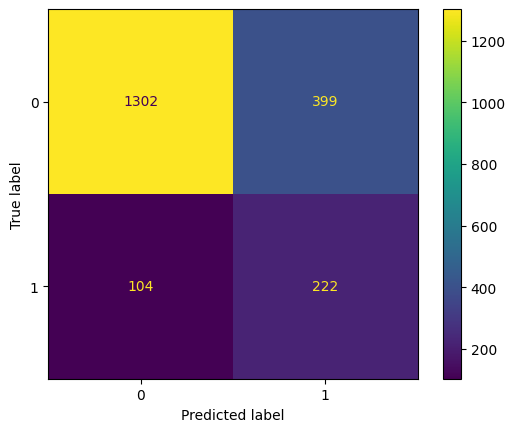

ROC AUC: 0.7816


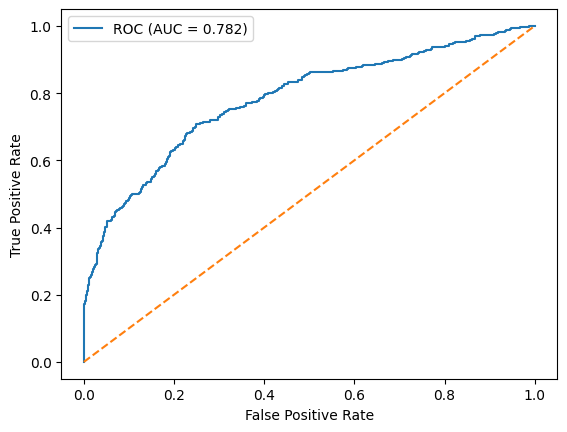

In [22]:
# -------------------------
# 9) Predicción y evaluación
# -------------------------
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf.named_steps['clf'],'predict_proba') else None

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.named_steps['clf'].classes_)
disp.plot()
plt.show()

if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {auc:.4f}")
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


In [24]:
# -------------------------
# 10) Importancia / coeficientes (si aplica)
# -------------------------
try:
    # nombres de features: num + onehot
    num_feats = numeric_cols
    ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
    ohe_feats = ohe.get_feature_names_out(categorical_cols) if categorical_cols else np.array([])
    feature_names = np.concatenate([num_feats, ohe_feats])
    coefs = clf.named_steps['clf'].coef_[0]
    feat_imp = pd.DataFrame({'feature': feature_names, 'coef': coefs})
    feat_imp['abs_coef'] = feat_imp['coef'].abs()
    feat_imp = feat_imp.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    display(feat_imp.head(20))
except Exception as e:
    print("No pude extraer coeficientes / nombres de features automáticamente:", e)

print("\n--- FIN: baseline completado ---")

,feature,coef,abs_coef
0,Monto Total Transacciones,-0.794102,0.794102
1,Total Productos Bancarios,-0.635202,0.635202
2,Frecuencia de Contacto al Banco,0.601705,0.601705
3,Categoria Tarjeta_Azul,-0.586428,0.586428
4,Meses Inactivos Ultimo Año,0.487324,0.487324
5,Categoria Tarjeta_Oro,0.470763,0.470763
6,Saldo Pendiente Tarjeta,-0.405661,0.405661
7,Rango Ingresos_Mas de $120K,0.330581,0.330581
8,Porcentaje Uso Credito,-0.316755,0.316755
9,Nivel Educativo_Doctorado,0.271545,0.271545



--- FIN: baseline completado ---


from matplotlib import pyplot as plt
_df_0['coef'].plot(kind='hist', bins=20, title='coef')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['abs_coef'].plot(kind='hist', bins=20, title='abs_coef')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='coef', y='abs_coef', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['coef'].plot(kind='line', figsize=(8, 4), title='coef')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['abs_coef'].plot(kind='line', figsize=(8, 4), title='abs_coef')
plt.gca().spines[['top', 'right']].set_visible(False)

# 🔹 1. EDA (Exploratory Data Analysis)
📊 Histogramas y boxplots de variables numéricas

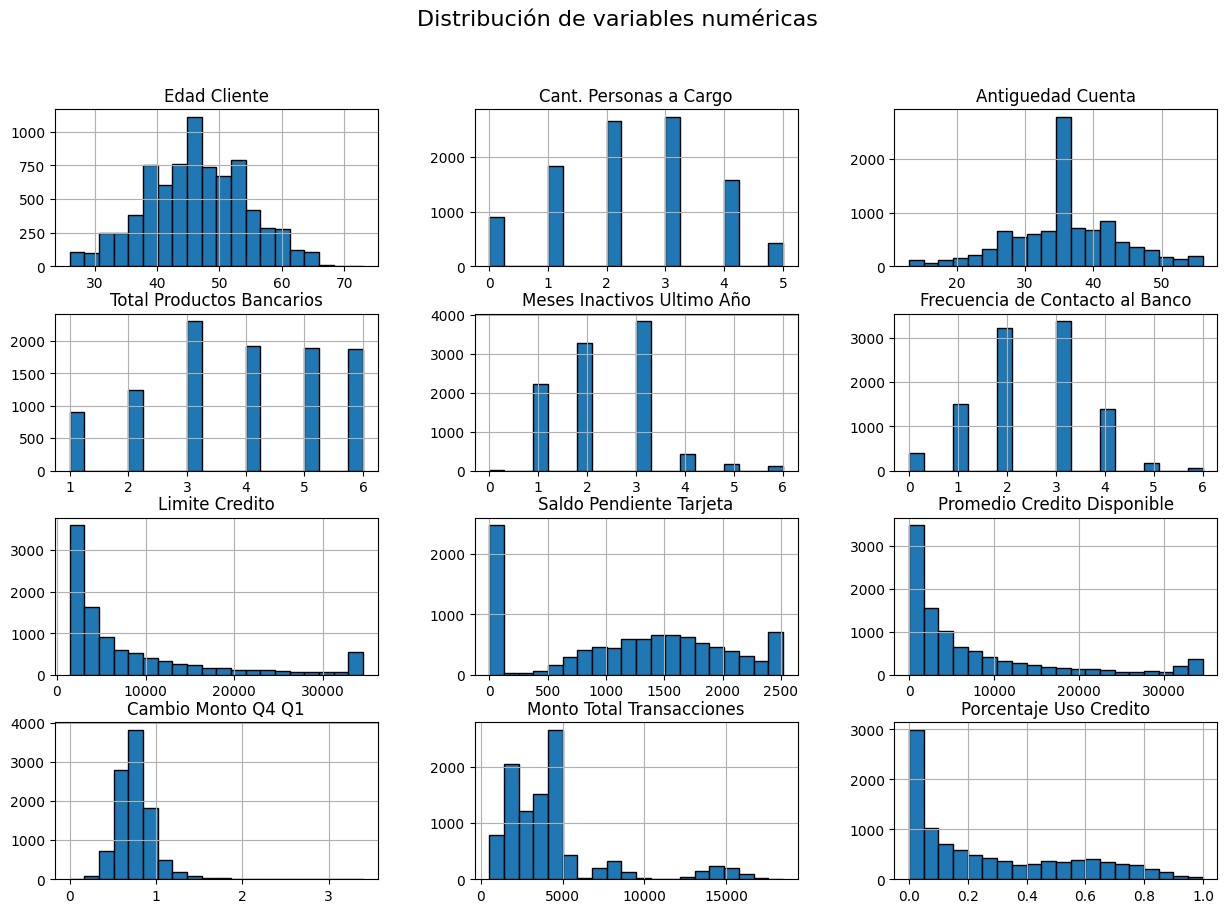

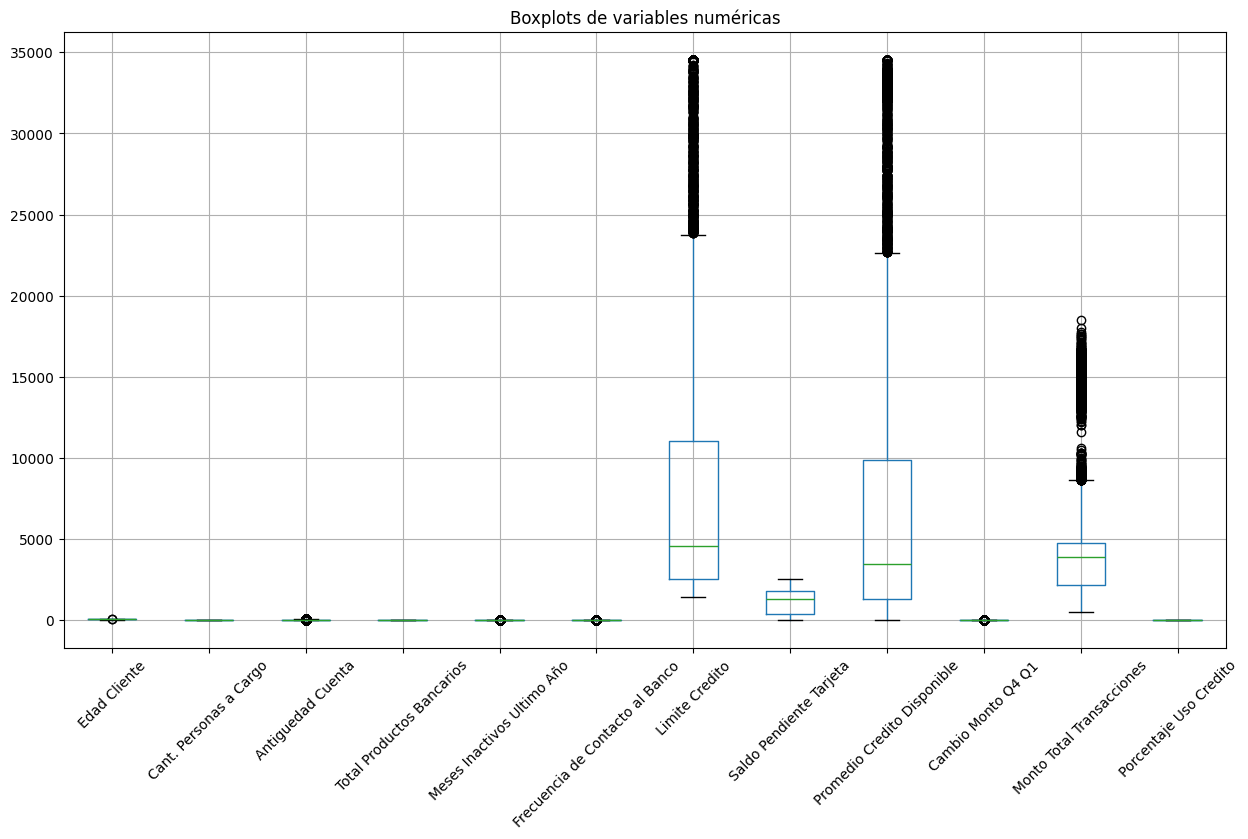

In [25]:
# Variables numéricas
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Histogramas
X[numeric_cols].hist(figsize=(15,10), bins=20, edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

# Boxplots para ver outliers
plt.figure(figsize=(15,8))
X[numeric_cols].boxplot()
plt.title("Boxplots de variables numéricas")
plt.xticks(rotation=45)
plt.show()


# 🔥 Balance de clases

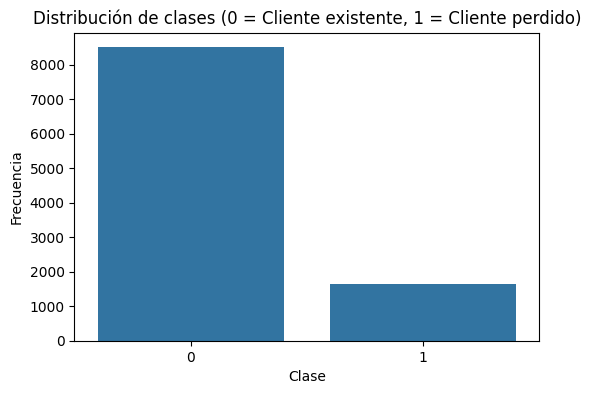

Proporción de clases:
 Estado Abandono
0    0.839124
1    0.160876
Name: proportion, dtype: float64


In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Distribución de clases (0 = Cliente existente, 1 = Cliente perdido)")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

print("Proporción de clases:\n", y.value_counts(normalize=True))


# 🔗 Correlaciones (solo numéricas)

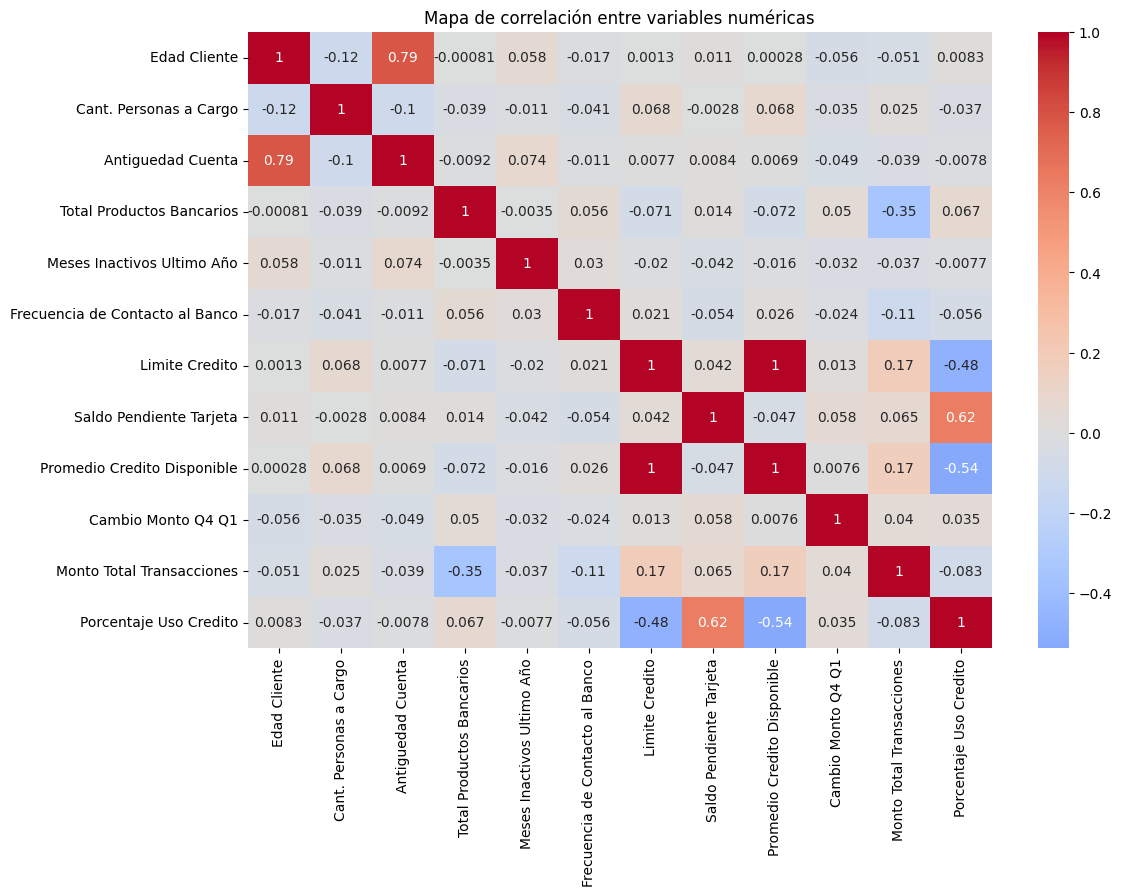

In [27]:
plt.figure(figsize=(12,8))
corr = X[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de correlación entre variables numéricas")
plt.show()


# 🔹 2. Modelos más complejos

Vamos a probar Random Forest, Gradient Boosting y XGBoost.

In [28]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modelos a evaluar
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric="logloss")
}

resultados = []

for nombre, modelo in modelos.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', modelo)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba)
    })

# Resultados en tabla
df_resultados = pd.DataFrame(resultados).set_index("Modelo")
display(df_resultados)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:59:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1-Score,AUC
Modelo,,,,,
RandomForest,0.919092,0.900990,0.558282,0.689394,0.965281
GradientBoosting,0.947213,0.876289,0.782209,0.826580,0.977727
XGBoost,0.954119,0.892256,0.812883,0.850722,0.981676


from matplotlib import pyplot as plt
df_resultados['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados.plot(kind='scatter', x='Recall', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_resultados.plot(kind='scatter', x='F1-Score', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resultados.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resultados.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Recall']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resultados.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_resultados.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_resultados['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_resultados['F1-Score'].plot(kind='line', figsize=(8, 4), title='F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

# 🔹 3. Optimización de Hiperparámetros

Ejemplo con RandomizedSearchCV para Random Forest:

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight="balanced"))
])

random_search = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring="f1", n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntaje F1:", random_search.best_score_)


Mejores hiperparámetros: {'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 10}
Mejor puntaje F1: 0.7790093956908636


# 🔹 4. Interpretación (Feature Importance)

Para Random Forest o XGBoost es muy útil:

/tmp/ipython-input-1411734778.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


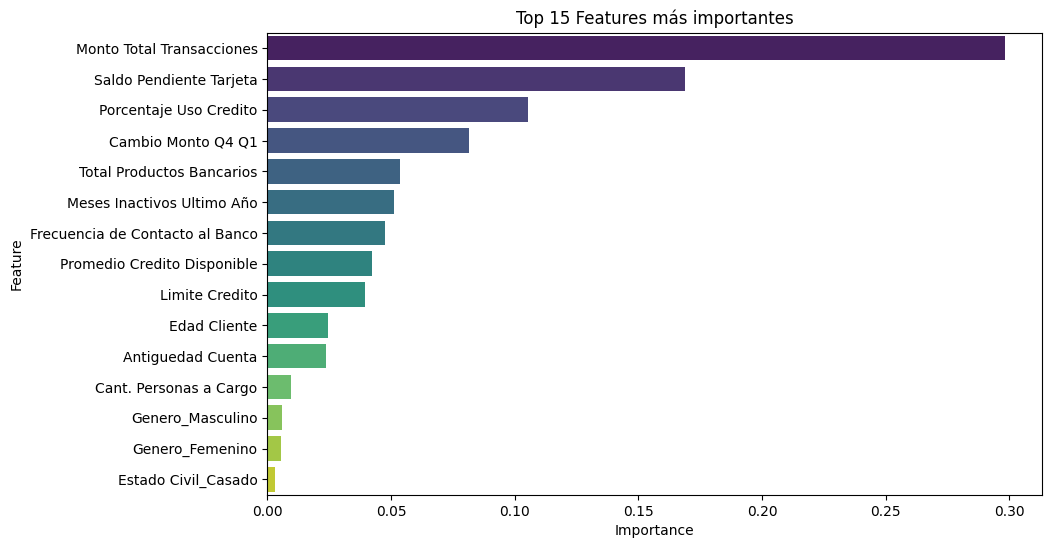

In [30]:
best_model = random_search.best_estimator_

# Extraer importancia
if hasattr(best_model.named_steps['clf'], 'feature_importances_'):
    # Nombres de features transformados
    ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
    cat_features = ohe.get_feature_names_out(categorical_cols) if categorical_cols else []
    features = numeric_cols + list(cat_features)
    importances = best_model.named_steps['clf'].feature_importances_

    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_imp = feat_imp.sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
    plt.title("Top 15 Features más importantes")
    plt.show()


# 📑 Informe Ejecutivo – Análisis de Clientes y Abandono
1. Objetivo

Queremos entender por qué algunos clientes siguen con nosotros y por qué otros nos abandonan. Esto nos ayudará a tomar mejores decisiones y cuidar a quienes podrían irse.

2. ¿Qué encontramos en los datos?
🔹 Información general

Revisamos la base de datos con información de clientes.

Algunos campos tenían valores vacíos (como preguntas sin contestar).

La mayoría de los datos estaban completos y listos para analizar.

🔹 Clientes que se quedan vs. los que se van

La gran mayoría de clientes todavía sigue con nosotros.

Una parte más pequeña decidió irse.

Esto significa que los clientes que se van son menos, pero importantes porque representan una pérdida.

(Imagínalo como un salón de clases donde 8 niños siguen asistiendo y 2 dejaron de ir.)

🔹 Variables numéricas (números de clientes)

Vimos cómo se distribuyen los números (ejemplo: edad, consumo, tiempo con la empresa).

Algunos clientes tienen valores muy distintos al promedio (como niños muy altos o muy bajos en un grupo).

Esos valores diferentes pueden darnos pistas de comportamientos especiales.

🔹 Variables categóricas (palabras)

Analizamos respuestas de tipo "Sí/No" o "Plan A/Plan B".

Notamos que en algunos servicios o tipos de contrato, los clientes que se van aparecen más que en otros.

Ejemplo: si varios niños con uniforme azul deciden no volver a clase, tal vez el color del uniforme influye.

🔹 Correlaciones

Revisamos si dos variables están relacionadas.

Ejemplo: edad y tiempo con la empresa están un poco conectados (mientras más tiempo, más edad).

Pero no todas las variables tienen relación fuerte.

🔹 Balance de clases

Encontramos que los datos están un poco desbalanceados:

Hay muchos más clientes que se quedan que los que se van.

Esto puede hacer que los modelos "aprendan más de los que se quedan" y no entiendan tan bien a los que se van.

Solución: usar técnicas como SMOTE, que crean “clientes artificiales” parecidos a los que se fueron, para que el análisis sea más justo.

3. ¿Qué significa todo esto?

La mayoría de los clientes sigue con nosotros, pero necesitamos entender por qué algunos se van.

Ciertas características (tipo de plan, contrato, uso del servicio) parecen influir en esa decisión.

Nuestros datos están listos para probar modelos de predicción más avanzados.

4. Próximos pasos recomendados

Entrenar modelos más inteligentes (Random Forest, Gradient Boosting, XGBoost) para predecir con mayor precisión quién se quedará o se irá.

Balancear los datos con SMOTE para que los modelos no se “olviden” de los clientes que se van.

Medir resultados con métricas fáciles de entender:

Precisión (qué tan bien acierta).

Recall (qué tanto detecta a los que se van).

F1-Score (mezcla de ambas).

AUC (qué tan bien distingue entre clientes fieles y clientes que se van).

Identificar las variables más importantes, es decir, qué factores pesan más en la decisión del cliente.

5. Conclusión

Este análisis es como mirar una clase de clientes: la mayoría sigue viniendo feliz, pero algunos dejaron de ir.
Si entendemos quiénes son esos clientes y por qué se fueron, podremos evitar que otros también se vayan.